<a href="https://colab.research.google.com/github/benawass/turbofan_design/blob/main/turbofan_design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Thrust Requirements

In [ ]:
# inputs
max_takeoff_mass_kg = 228_000
max_fuel_burn_kg = 60_000
cruise_speed_mach = 0.85
cruise_lift_to_drag_ratio = 21
number_engines = 2;

In [ ]:
# find design point conditions
end_mass = max_takeoff_mass_kg - max_fuel_burn_kg
mid_cruise_mass_kg = (max_takeoff_mass_kg + end_mass)/2

# find net cruise thrust
# in level, steady flight: lift = weight, drag = thrust
mid_cruise_weight_N = mid_cruise_mass_kg * 9.81

# use CLDR to find thrust required at cruise
total_cruise_thrust_N = mid_cruise_weight_N / cruise_lift_to_drag_ratio

# boeing 787-8 has two engines
engine_cruise_thrust_N = total_cruise_thrust_N / number_engines;
display(engine_cruise_thrust_N)

46247.142857142855

# Standard Atmosphere Function
Install the 'ambiance' package, then define a Python function `get_atmospheric_properties` that takes altitude (in meters) and Mach number as inputs. This function should use 'ambiance' to calculate static pressure, static temperature, and air density. It should then calculate the speed of sound, stagnation temperature, and stagnation pressure (converting stagnation pressure to bar). Finally, the function should return the calculated stagnation pressure (in bar), stagnation temperature (in Kelvin), air density (kg/m^3), and speed of sound (m/s).

## Install Ambiance Package

### Subtask:
Install the 'ambiance' package, which provides functionalities for standard atmosphere calculations, using pip.


In [ ]:
!pip install ambiance

## Define get_atmospheric_properties Function



In [ ]:
import numpy as np # Import numpy for sqrt

def get_atmospheric_properties(height_m):
    from ambiance import Atmosphere

    # Create an Atmosphere instance
    atm = Atmosphere(height_m)

    # Access static atmospheric properties
    P = atm.pressure[0] # Pascals
    T = atm.temperature[0] # Kelvin
    rho = atm.density[0] # kg/m^3

    # Calculate speed of sound
    gamma = 1.4  # Ratio of specific heats for air
    R = 287.05   # Gas constant for dry air (J/(kg*K))
    a = np.sqrt(gamma * R * T)

    return {'P': P, 'T': T, 'rho': rho, 'a': a}

get_atmospheric_properties(11_000)

{'P': np.float64(22699.93683700412),
 'T': np.float64(216.77351270445553),
 'rho': np.float64(0.36480143683538285),
 'a': np.float64(295.1521159513168)}

# Intake Stagnation values
- Inputs: $M$, $T_a$, $P_a$, $γ_a$, $\eta_d$ (mach number, atmospheric conditions and diffuser efficency)
- Outputs: $T_{01}$ and $P_{01}$

In [ ]:
# example inputs

# for inlet values
mach_number = 0.85
diffuser_eff = 0.9
P_atm = 0.1e6
T_atm = 288
gamma_a = 1.4

# for fan exit values
fan_stag_P_ratio = 2
fan_eff = 0.85

# for core compressor exit values
core_stag_P_ratio = 10
core_compressor_eff = 0.85

# for combustor exit values
fuel_to_mass_ratio = 0.0160
c_pa = 1.01e3 # DOESNT WORK WHEN IN CORRECT UNITS x10^2 as KJ ???
c_pp = 1.10e3 # DOESNT WORK WHEN IN CORRECT UNITS x10^2 as KJ ???
Q_r = 43e6 # (calorific value of fuel / kg)
combust_stag_P_ratio = 0.97

In [ ]:
all_station_values = {}
all_station_values.update({'T_atm': T_atm, 'P_atm': P_atm})
def get_intake_values(mach_number, diffuser_eff, P_atm, T_atm, gamma_a):
  # find real and ideal stagnation temps
  T_01 = T_atm*(1 + ((gamma_a-1)/2)*mach_number**2)
  T_01s = T_atm + diffuser_eff*(T_01 - T_atm)

  # find real and ideal stagnation pressures
  P_01s = P_atm*(T_01s/T_atm)**(gamma_a/(gamma_a-1))
  P_01 = P_01s
  return {'T_01': T_01, 'P_01': P_01, 'T_01s': T_01s, 'P_01s': P_01s}

# run func
intake_values = get_intake_values(mach_number, diffuser_eff, P_atm, T_atm, gamma_a)
all_station_values.update(intake_values)
display(intake_values)

# save values
T_01 = all_station_values['T_01']
P_01 = all_station_values['P_01']

{'T_01': 329.616,
 'P_01': 153405.81019950192,
 'T_01s': 325.45439999999996,
 'P_01s': 153405.81019950192}

In [ ]:
def get_fan_exit_values(fan_stag_P_ratio, fan_eff, P_01, T_01, gamma_a):
  # ideal and real stag pressures
  P_02s = fan_stag_P_ratio*P_01
  P_02 = P_02s

  # ideal and real stag temps
  T_02s = T_01 * fan_stag_P_ratio**((gamma_a-1)/gamma_a)
  T_02 = T_01 + (1/fan_eff)*(T_02s-T_01)
  return {'T_02': T_02, 'P_02': P_02, 'T_02s': T_02s, 'P_02s': P_02s}

# run func
fan_exit_values = get_fan_exit_values(fan_stag_P_ratio, fan_eff, P_01, T_01, gamma_a)
all_station_values.update(fan_exit_values)
display(fan_exit_values)

# save values
T_02 = fan_exit_values['T_02']
P_02 = fan_exit_values['P_02']

{'T_02': 414.5458878167792,
 'P_02': 306811.62039900385,
 'T_02s': 401.80640464426233,
 'P_02s': 306811.62039900385}

In [ ]:
def get_compressor_exit_values(core_stag_P_ratio, core_compressor_eff, P_02, T_02, gamma_a):
  # ideal and real stag pressures
  P_03s = core_stag_P_ratio*P_02
  P_03 = P_03s

  # ideal and real stag temps
  T_03s = T_02 * core_stag_P_ratio**((gamma_a-1)/gamma_a)
  T_03 = T_02 + (1/core_compressor_eff)*(T_03s-T_02)
  return {'T_03': T_03, 'P_03': P_03, 'T_03s': T_03s, 'P_03s': P_03s}

# run func
compressor_exit_values = get_compressor_exit_values(core_stag_P_ratio, core_compressor_eff, P_02, T_02, gamma_a)
all_station_values.update(compressor_exit_values)
display(compressor_exit_values)

# save values
T_03 = compressor_exit_values['T_03']
P_03 = compressor_exit_values['P_03']

{'T_03': 868.4481422979168,
 'P_03': 3068116.2039900385,
 'T_03s': 800.3628041257462,
 'P_03s': 3068116.2039900385}

In [ ]:
def get_combustor_exit_values(c_pa, c_pp, fuel_to_mass_ratio, Q_r, combust_stag_P_ratio, T_03, P_03):
  # energy balance for fuel burnt
  T_04 = ((c_pa*T_03) + (fuel_to_mass_ratio*Q_r))/((1+fuel_to_mass_ratio)*c_pp)

  # combust pressure ratio to find pressure
  P_04 = P_03 * combust_stag_P_ratio

  return {'T_04': T_04, 'P_04': P_04}

# run func
combustor_exit_values = get_combustor_exit_values(c_pa, c_pp, fuel_to_mass_ratio, Q_r, combust_stag_P_ratio, T_03, P_03)
all_station_values.update(combustor_exit_values)
display(combustor_exit_values)

# save values
T_04 = combustor_exit_values['T_04']
P_04 = combustor_exit_values['P_04']

{'T_04': 1400.4407871518397, 'P_04': 2976072.7178703374}

# Turbine work

In [ ]:
# more definitons
bypass_ratio = 1
turb_eff = 0.88
gamma_c = 1.33
nozzle_eff = 0.96
R_c = c_pp * ((gamma_c-1)/gamma_c)
R_a = c_pa * ((gamma_a-1)/gamma_a)
core_nozzle_area_m2 = 0.5

In [ ]:
# NOTE USE OF GAMMA_C as has been combusted already
def get_turbine_exit_values(bypass_ratio, c_pa, c_pp, turb_eff, all_station_values, gamma_c):
  # extract relevant values
  T_01 = all_station_values['T_01']
  T_02 = all_station_values['T_02']
  T_03 = all_station_values['T_03']
  T_04 = all_station_values['T_04']

  # find T deltas
  delta_T_compressor = T_03 - T_02
  delta_T_fan = T_02 - T_01

  # find temp change in turbine
  delta_T_turbine = ((c_pa*delta_T_compressor) + (1+bypass_ratio)*(c_pa*delta_T_fan))/c_pp

  # find ideal and real temps at exit of turbine
  T_05 = T_04 - delta_T_turbine
  T_05s = T_04 - (delta_T_turbine/turb_eff)

  # find ideal and real pressures at exit of turbine
  P_05 = P_04 * (T_05s / T_04) ** (gamma_c / (gamma_c - 1))
  return {'T_05': T_05, 'P_05': P_05, 'T_05s': T_05s,}

# run func
turbine_exit_values = get_turbine_exit_values(bypass_ratio, c_pa, c_pp, turb_eff, all_station_values, gamma_c)
all_station_values.update(turbine_exit_values)
display(turbine_exit_values)

{'T_05': 827.7138322283462,
 'P_05': 239724.19427074664,
 'T_05s': 749.6147020115062}

# Core Nozzle

In [ ]:
import numpy as np
def get_choked_core_nozzle_exit_values(all_station_values, gamma_c, nozzle_eff, c_pp, R_c, core_nozzle_area_m2):
  # get relevant values
  T_05 = all_station_values['T_05']
  P_05 = all_station_values['P_05']
  T_06 = T_05

  # find temps
  T_6 = T_06/((gamma_c+1)/2)
  T_6s = T_05 - ((T_05-T_6)/nozzle_eff)

  # find speed via SFEE
  u_6 = np.sqrt(2*c_pp*(T_06-T_6))

  # find pressures (isen temp/pressure relationship)
  P_6 = P_05 * (T_6s/T_05)**(gamma_c/(gamma_c-1))

  # find density at exit using ideal gas law
  rho_6 = P_6/(R_c*T_6);

  # mass flow rate of air through core
  mass_flow_core = rho_6 * core_nozzle_area_m2 * u_6

  return {'T_6': T_6, 'T_06':T_06, 'u_6': u_6, 'T_6s': T_6s, 'P_6': P_6, 'rho_6': rho_6, 'mass_flow_core': mass_flow_core}

core_nozzle_values = get_choked_core_nozzle_exit_values(all_station_values, gamma_c, nozzle_eff, c_pp, R_c, core_nozzle_area_m2)
all_station_values.update(core_nozzle_values)
display(core_nozzle_values)

{'T_6': 710.4839761616705,
 'T_06': 827.7138322283462,
 'u_6': np.float64(507.84415261641686),
 'T_6s': 705.599398825559,
 'P_6': 125986.25234630307,
 'rho_6': 0.649701524395414,
 'mass_flow_core': np.float64(164.97356005509164)}

# Bypass Nozzle

In [ ]:

def get_choked_bypass_nozzle_exit_values(all_station_values, gamma_a, c_pa, R_a, bypass_ratio, nozzle_eff):
  # get relevant temps
  T_02 = all_station_values['T_02']
  T_06 = all_station_values['T_06']
  mass_flow_core = all_station_values['mass_flow_core']
  P_02 = all_station_values['P_02']

  # calculate temps
  T_07 = T_02
  T_7 = T_07/((gamma_a+1)/2) # using gamma a here as BYPASSES COMBUSTION
  T_7s = T_07 - ((T_07-T_7)/nozzle_eff)

  # calculate speed
  u_7 = np.sqrt(2*c_pa*(T_07-T_7))

  # find pressure
  P_7s = P_02 * (T_7s/T_02)**(gamma_a/(gamma_a-1))
  P_7 = P_7s # nozzle therefore no work done

  # find density
  rho_7 = P_7/(R_a*T_7)

  # find bypass flow rate
  mass_flow_bypass = bypass_ratio * mass_flow_core

  # find bypass area
  bypass_area_m2 = mass_flow_bypass / (rho_7 * u_7)

  # return vars
  return {'T_7': T_7, 'T_7s': T_7s, 'T_07':T_07, 'u_7': u_7, 'P_7':P_7, 'P_7s': P_7s, 'rho_7':rho_7, 'mass_flow_bypass': mass_flow_bypass, 'bypass_area_m2':bypass_area_m2}


choked_bypass_nozzle_values = get_choked_bypass_nozzle_exit_values(all_station_values, gamma_a, c_pa, R_a, bypass_ratio, nozzle_eff)
all_station_values.update(choked_bypass_nozzle_values)
display(choked_bypass_nozzle_values)

{'T_7': 345.4549065139827,
 'T_7s': 342.5761156263661,
 'T_07': 414.5458878167792,
 'u_7': np.float64(373.58236338409904),
 'P_7': 157404.6097318175,
 'P_7s': 157404.6097318175,
 'rho_7': 1.5789659043402728,
 'mass_flow_bypass': np.float64(164.97356005509164),
 'bypass_area_m2': np.float64(0.279676018956477)}

# Find Thrust from engine design

In [ ]:
def get_thrust(all_station_values, mach_cruise, altitude, core_nozzle_area_m2):
  # mass and area of core & bypass
  mass_flow_core = all_station_values['mass_flow_core']
  mass_flow_bypass = all_station_values['mass_flow_bypass']
  bypass_area_m2 = all_station_values['bypass_area_m2']

  # extract speeds out of core and bypass
  u_6 = all_station_values['u_6']
  u_7 = all_station_values['u_7']

  # find inlet speed of sound at altitude
  atm_values = get_atmospheric_properties(altitude)
  a_1 = atm_values['a']
  u_1 = a_1 * mach_cruise

  # pressure at bypass and core exits
  P_6 = all_station_values['P_6']
  P_7 = all_station_values['P_7']
  P_atm = all_station_values['P_atm']


  core_thrust = mass_flow_core*(u_6 - u_1) + (P_6 - P_atm)*core_nozzle_area_m2
  bypass_thrust = mass_flow_bypass*(u_7 - u_1) + (P_7 - P_atm)*bypass_area_m2
  print(f'Core Thrust: {core_thrust} N')
  print(f'Bypass Thrust: {bypass_thrust} N')
  total_thrust = core_thrust + bypass_thrust
  return total_thrust

def get_TSFC(f, all_station_values, thrust):
  TSFC =(f * all_station_values['mass_flow_core'])/thrust
  return TSFC

thrust = get_thrust(all_station_values, mach_number, 0, core_nozzle_area_m2)
TSFC = get_TSFC(fuel_to_mass_ratio, all_station_values, thrust)
display(thrust)
display(TSFC)

Core Thrust: 88294.87950642547 N
Bypass Thrust: 29967.559660879422 N


np.float64(118262.4391673049)

np.float64(2.854126012023211e-05)

# Thrust within 3% of his answer - hope rounding error

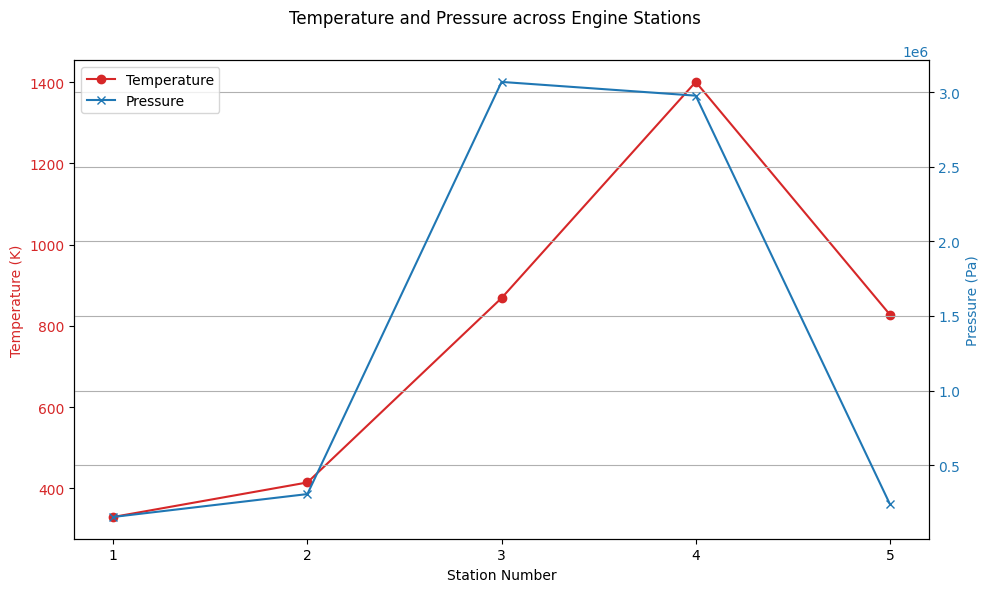

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# static find the maximum station number
max_station = 5

# Station numbers
stations = list(range(1, max_station + 1))

# Temperature values
temperatures = [all_station_values[f'T_0{i}'] for i in stations]

# Pressure values
pressures = [all_station_values[f'P_0{i}'] for i in stations]

# Create a figure and a set of subplots with a shared x-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot temperature on the first y-axis
color = 'tab:red'
ax1.set_xlabel('Station Number')
ax1.set_ylabel('Temperature (K)', color=color)
ax1.plot(stations, temperatures, color=color, marker='o', label='Temperature')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(stations)

# Create a second y-axis for pressure
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Pressure (Pa)', color=color)
ax2.plot(stations, pressures, color=color, marker='x', label='Pressure')
ax2.tick_params(axis='y', labelcolor=color)

# Add a title and legend
fig.suptitle('Temperature and Pressure across Engine Stations')

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlapping elements
plt.show()

In [ ]:
all_station_values

{'T_atm': 288,
 'P_atm': 100000.0,
 'T_01': 329.616,
 'P_01': 153405.81019950192,
 'T_01s': 325.45439999999996,
 'P_01s': 153405.81019950192,
 'T_02': 414.5458878167792,
 'P_02': 306811.62039900385,
 'T_02s': 401.80640464426233,
 'P_02s': 306811.62039900385,
 'T_03': 868.4481422979168,
 'P_03': 3068116.2039900385,
 'T_03s': 800.3628041257462,
 'P_03s': 3068116.2039900385,
 'T_04': 1400.4407871518397,
 'P_04': 2976072.7178703374,
 'T_05': 827.7138322283462,
 'P_05': 239724.19427074664,
 'T_05s': 749.6147020115062,
 'T_6': 710.4839761616705,
 'T_06': 827.7138322283462,
 'u_6': np.float64(507.84415261641686),
 'T_6s': 705.599398825559,
 'P_6': 125986.25234630307,
 'rho_6': 0.649701524395414,
 'mass_flow_core': np.float64(164.97356005509164),
 'T_7': 345.4549065139827,
 'T_7s': 342.5761156263661,
 'T_07': 414.5458878167792,
 'u_7': np.float64(373.58236338409904),
 'P_7': 157404.6097318175,
 'P_7s': 157404.6097318175,
 'rho_7': 1.5789659043402728,
 'mass_flow_bypass': np.float64(164.9735600

## Create Unified Turbofan Performance Function

### Subtask:
Define a new Python function `calculate_turbofan_engine_performance` that encapsulates the entire turbofan engine cycle analysis by sequentially calling existing functions. It will accept specified parameters, store all intermediate values in a single `all_station_values` dictionary, and return this dictionary along with the final calculated thrust.


In [ ]:
def calculate_turbofan_engine_performance(
    # flight conditions
    altitude_m, # As used in the final get_thrust call
    mach_cruise,

    # efficencys
    diffuser_eff,
    core_compressor_eff,
    fan_eff,
    turb_eff,
    nozzle_eff,

    # pressure ratios
    fan_stag_P_ratio,
    core_stag_P_ratio,
    combust_stag_P_ratio,

    # f value
    fuel_to_mass_ratio,


    # air  & combustion product values
    c_pa,
    c_pp,
    gamma_a,
    gamma_c,
    Q_r,

    # bypass and nozzle area
    overall_bypass_ratio,
    core_nozzle_area_m2):

    # Initialize an empty dictionary for all station values
    all_station_values = {}

    # 3. Call get_atmospheric_properties and store results
    atm_properties = get_atmospheric_properties(altitude_m)
    all_station_values['P_atm'] = atm_properties['P']
    all_station_values['T_atm'] = atm_properties['T']
    all_station_values['rho_atm'] = atm_properties['rho']
    all_station_values['a_atm'] = atm_properties['a']

    # 4. Call get_intake_values
    intake_values = get_intake_values(
        mach_cruise,
        diffuser_eff,
        all_station_values['P_atm'],
        all_station_values['T_atm'],
        gamma_a
    )
    all_station_values.update(intake_values)

    # 5. Call get_fan_exit_values
    fan_exit_values = get_fan_exit_values(
        fan_stag_P_ratio,
        fan_eff,
        all_station_values['P_01'],
        all_station_values['T_01'],
        gamma_a
    )
    all_station_values.update(fan_exit_values)

    # 6. Call compressor_exit_values
    compressor_exit_results = get_compressor_exit_values(
        core_stag_P_ratio,
        core_compressor_eff,
        all_station_values['P_02'],
        all_station_values['T_02'],
        gamma_a
    )
    all_station_values.update(compressor_exit_results)

    # 7. Call get_combustor_exit_values
    combustor_exit_results = get_combustor_exit_values(
        c_pa,
        c_pp,
        fuel_to_mass_ratio,
        Q_r,
        combust_stag_P_ratio,
        all_station_values['T_03'],
        all_station_values['P_03']
    )
    all_station_values.update(combustor_exit_results)

    # 8. Calculate R_c and R_a within the function
    R_c = c_pp * ((gamma_c - 1) / gamma_c)
    R_a = c_pa * ((gamma_a - 1) / gamma_a)
    all_station_values['R_c'] = R_c
    all_station_values['R_a'] = R_a

    # 9. Call get_turbine_exit_values
    turbine_exit_results = get_turbine_exit_values(
        overall_bypass_ratio,
        c_pa,
        c_pp,
        turb_eff,
        all_station_values,
        gamma_c
    )
    all_station_values.update(turbine_exit_results)

    # 10. Call get_choked_core_nozzle_exit_values
    core_nozzle_results = get_choked_core_nozzle_exit_values(
        all_station_values,
        gamma_c,
        nozzle_eff,
        c_pp,
        R_c,
        core_nozzle_area_m2
    )
    all_station_values.update(core_nozzle_results)

    # 11. Call get_choked_bypass_nozzle_exit_values
    bypass_nozzle_results = get_choked_bypass_nozzle_exit_values(
        all_station_values,
        gamma_a,
        c_pa,
        R_a,
        overall_bypass_ratio,
        nozzle_eff
    )
    all_station_values.update(bypass_nozzle_results)

    # 12. Call get_thrust
    final_thrust = get_thrust(
        all_station_values,
        mach_cruise,
        altitude_m,
        core_nozzle_area_m2
    )

    # 13. Call get_TSFC
    TSFC = get_TSFC(fuel_to_mass_ratio, all_station_values, final_thrust)

    # 14. Return the dictionary and final_thrust
    return all_station_values, final_thrust, TSFC

print("Function 'calculate_turbofan_engine_performance' defined.")

Function 'calculate_turbofan_engine_performance' defined.


# RUN FUNC ON EXAMPLE TO VERIFY

In [ ]:
# EXAMPLE
# flight conditions
altitude_m = 0 # As used in the final get_thrust call
mach_cruise = 0.85

# efficencys
diffuser_eff = 0.9
core_compressor_eff = 0.85
fan_eff = 0.85
turb_eff = 0.88
nozzle_eff = 0.96

# pressure ratios
fan_stag_P_ratio_val = 2
core_stag_P_ratio_val = 10
combust_stag_P_ratio_val = 0.97

# f value
fuel_to_mass_ratio_val = 0.0160

# air  & combustion product values
c_pa = 1.01e3
c_pp = 1.10e3
gamma_a = 1.4
gamma_c= 1.33
Q_r = 43_000e3

# nozzle exit area
core_nozzle_area_m2 = 0.5

# bypass ratio
overall_bypass_ratio = 1

all_example_results, final_thrust, final_TSFC = calculate_turbofan_engine_performance(
    # flight conditions
    altitude_m, # As used in the final get_thrust call
    mach_cruise,

    # efficencys
    diffuser_eff,
    core_compressor_eff,
    fan_eff,
    turb_eff,
    nozzle_eff,

    # pressure ratios
    fan_stag_P_ratio,
    core_stag_P_ratio,
    combust_stag_P_ratio,

    # f value
    fuel_to_mass_ratio,

    # air  & combustion product values
    c_pa,
    c_pp,
    gamma_a,
    gamma_c,
    Q_r,

    # bypass and nozzle area
    overall_bypass_ratio,
    core_nozzle_area_m2)

print("All Station Values:")
display(all_example_results)
print("\nFinal Calculated Thrust:")
display(final_thrust)
print("\nFinal Calculated TSFC:")
display(final_TSFC)

Core Thrust: 29604.015329554208 N
Bypass Thrust: 13056.958334569543 N
All Station Values:


{'P_atm': np.float64(101325.0),
 'T_atm': np.float64(288.15),
 'rho_atm': np.float64(1.225000018124288),
 'a_atm': np.float64(340.29228686527705),
 'T_01': np.float64(329.7876749999999),
 'P_01': np.float64(155438.43718464533),
 'T_01s': np.float64(325.6239074999999),
 'P_01s': np.float64(155438.43718464533),
 'T_02': np.float64(380.7297281589509),
 'P_02': np.float64(239375.19326435382),
 'T_02s': np.float64(373.08842018510825),
 'P_02s': np.float64(239375.19326435382),
 'T_03': np.float64(1143.6754628940234),
 'P_03': np.float64(7775337.1525740875),
 'T_03s': np.float64(1029.2336026837625),
 'P_03s': np.float64(7775337.1525740875),
 'T_04': np.float64(1812.811884767622),
 'P_04': np.float64(7386570.2949453825),
 'R_c': 272.9323308270677,
 'R_a': 288.5714285714285,
 'T_05': np.float64(1018.7408488917089),
 'P_05': np.float64(185442.665920992),
 'T_05s': np.float64(910.4584349086298),
 'T_6': np.float64(874.4556642847286),
 'T_06': np.float64(1018.7408488917089),
 'u_6': np.float64(563


Final Calculated Thrust:


np.float64(42660.973664123754)


Final Calculated TSFC:


np.float64(5.516901793263962e-05)

# MY DESIGN CHOICES: JUSTIFY ASSUMPTIONS

# Assumptions
- look at chap 7 (pg 82): [Jet Propulsion Book](https://discover.durham.ac.uk/discovery/fulldisplay?docid=cdi_proquest_ebookcentral_EBC3563546&context=PC&vid=44DUR_INST:VU1&lang=en&search_scope=MyInst_and_CI&adaptor=Primo%20Central&tab=Everything&query=any,contains,Cumpsty%20and%20Heyes%20(2015))
- bypass ratio of 10:1 sourced from [Rolls Royce Trent 1000](https://www.rolls-royce.com/products-and-services/civil-aerospace/widebody/trent-1000.aspx#section-overview)
- fan diameter of 2.8m sourced from [Rolls Royce Trent 1000](https://www.rolls-royce.com/products-and-services/civil-aerospace/widebody/trent-1000.aspx#section-overview)
- fuel to mass ratio same value as example: 0.0160 (assume fuel flow rate cooling air bleed flow rate)[turbofan example handout 4](https://blackboard.durham.ac.uk/ultra/courses/_67951_1/outline/edit/document/_3150441_1?courseId=_67951_1&view=content&state=view)
- [Trent 1000-A Turbofan Performance Analysis](https://www.scribd.com/document/818252194/PerformanceanalysisofhighbypassTurbofanengineTrent1000-A)
  - Fuel Heating Value(KJ/Kg) 45000
  - Fan Pressure Ratio: 1.54
  - air mass flow rate at cruise (kg/s)  600
  - fuel mass flow rate at cruise (kg/s) 1.116
  - IPC Intermediate Pressure Compressor Pressure Ratio 9.61
  - HPC High Pressure Compressor Pressure Ratio 3.38
- D = 63" => r = 0.8m => core nozzle exit area = 2.01m2 [some dodgy presentation](https://web.archive.org/web/20170702144003/https://www.faa.gov/about/office_org/headquarters_offices/apl/research/aircraft_technology/cleen/2012_consortium/media/Boeing_CLEEN_Projects_Briefing.pdf)


In [ ]:
# MY DESIGN

# flight conditions
altitude_m = 11_000 # Assumption, cruise altitude
mach_cruise = 0.85 # Given

# efficencys
diffuser_eff = 0.98
core_compressor_eff = 0.91
fan_eff = 0.93
turb_eff = 0.93
nozzle_eff = 0.95

# pressure ratios
fan_stag_P_ratio = 1.54

# combine Intermediate and high pressure compressor ratios
IPC_P_ratio = 9.61
HPC_P_ratio = 3.38
core_stag_P_ratio = IPC_P_ratio * HPC_P_ratio

combust_stag_P_ratio = 0.95 # NEED BETTER VALUE

# bypass ratio
overall_bypass_ratio = 10

# f value
air_mass_flow_rate = 600
m_core = air_mass_flow_rate / (1 + overall_bypass_ratio)
fuel_mass_flow_rate = 1.116
fuel_to_mass_ratio = 1.116/m_core

# air  & combustion product values (constants)
c_pa = 1.01e3
c_pp = 1.10e3
gamma_a = 1.4
gamma_c= 1.33
Q_r = 45e6 # NEED TO JUSTIFY

# nozzle exit area
core_nozzle_area_m2 = 2.01


all_design_results, final_thrust, final_TSFC = calculate_turbofan_engine_performance(
    # flight conditions
    altitude_m,
    mach_cruise,

    # efficencys
    diffuser_eff,
    core_compressor_eff,
    fan_eff,
    turb_eff,
    nozzle_eff,

    # pressure ratios
    fan_stag_P_ratio,
    core_stag_P_ratio,
    combust_stag_P_ratio,

    # f value
    fuel_to_mass_ratio,

    # air  & combustion product values
    c_pa,
    c_pp,
    gamma_a,
    gamma_c,
    Q_r,

    # bypass and nozzle area
    overall_bypass_ratio,
    core_nozzle_area_m2)

print("All Station Values:")
display(all_design_results)
print("\nFinal Calculated Thrust:")
display(final_thrust)
print("\nFinal Calculated TSFC:")
display(final_TSFC)

Core Thrust: 104375.4674662642 N
Bypass Thrust: 265102.4902503867 N
All Station Values:


{'P_atm': np.float64(22699.93683700412),
 'T_atm': np.float64(216.77351270445553),
 'rho_atm': np.float64(0.36480143683538285),
 'a_atm': np.float64(295.1521159513168),
 'T_01': np.float64(248.09728529024932),
 'P_01': np.float64(36085.840399501736),
 'T_01s': np.float64(247.47080983853346),
 'P_01s': np.float64(36085.840399501736),
 'T_02': np.float64(283.12404904082155),
 'P_02': np.float64(55572.194215232674),
 'T_02s': np.float64(280.6721755782815),
 'P_02s': np.float64(55572.194215232674),
 'T_03': np.float64(813.0694831578871),
 'P_03': np.float64(1805084.8980603446),
 'T_03s': np.float64(765.3743940873513),
 'P_03s': np.float64(1805084.8980603446),
 'T_04': np.float64(1551.795872796641),
 'P_04': np.float64(1714830.6531573273),
 'R_c': 272.9323308270677,
 'R_a': 288.5714285714285,
 'T_05': np.float64(711.4392966811014),
 'P_05': np.float64(88230.06023412962),
 'T_05s': np.float64(648.1866511670286),
 'T_6': np.float64(610.6775078807736),
 'T_06': np.float64(711.4392966811014),
 


Final Calculated Thrust:


np.float64(369477.9577166509)


Final Calculated TSFC:


np.float64(1.4472442190203378e-05)

# Sanity check
369kN thrust not crazy! see [Type Certification Data Sheet pg13 for real values](https://web.archive.org/web/20220127120930/https://www.easa.europa.eu/sites/default/files/dfu/TCDS%20E%20036%20issue%2015.pdf)

In [ ]:
def validate_choked_nozzles(all_station_values, gamma_air, gamma_gas):
    """
    Validates the choked flow condition for a turbofan's core
    and bypass nozzles using a dictionary of station values.

    A nozzle is choked if its actual Nozzle Pressure Ratio (NPR)
    is greater than the critical Nozzle Pressure Ratio (NPR_crit).
    """

    print("--- Nozzle Choked Flow Validation ---")


    # --- 2. Extract Required Values from Dictionary ---
    try:
        P_a = all_station_values['P_atm']
        P_t_bypass = all_station_values['P_02'] # Stagnation pressure at fan exit
        P_t_core = all_station_values['P_05']   # Stagnation pressure at LPT exit

        # Check if values are zero, which would cause errors
        if P_a == 0:
            print("ERROR: Ambient pressure 'P_atm' is zero.")
            return

    except KeyError as e:
        print(f"ERROR: Missing expected key in dictionary: {e}")
        print("Function requires 'P_atm', 'P_02', and 'P_05'.")
        return
    except Exception as e:
        print(f"An unexpected error occurred extracting data: {e}")
        return

    # --- 3. Bypass Nozzle Calculation ---

    # Calculate critical NPR for the bypass nozzle (Air, gamma = 1.4)
    npr_crit_bypass = ((gamma_air + 1) / 2) ** (gamma_air / (gamma_air - 1))

    # Calculate actual NPR for the bypass nozzle
    npr_actual_bypass = P_t_bypass / P_a

    print("\n[1] Bypass Nozzle (Fan Nozzle)")
    print(f"  Stagnation Pressure (P_02): {P_t_bypass:,.2f} Pa")
    print(f"  Ambient Pressure (P_atm):   {P_a:,.2f} Pa")
    print(f"  Actual NPR (P_02 / P_atm):  {npr_actual_bypass:.3f}")
    print(f"  Critical NPR (gamma=1.4):   {npr_crit_bypass:.3f}")

    if npr_actual_bypass > npr_crit_bypass:
        print("  STATUS: CHOKED")
    else:
        print("  STATUS: UNCHOKED")

    # --- 4. Core Nozzle Calculation ---

    # Calculate critical NPR for the core nozzle (Gas, gamma = 1.33)
    npr_crit_core = ((gamma_gas + 1) / 2) ** (gamma_gas / (gamma_gas - 1))

    # Calculate actual NPR for the core nozzle
    npr_actual_core = P_t_core / P_a

    print("\n[2] Core Nozzle (Turbine Nozzle)")
    print(f"  Stagnation Pressure (P_05): {P_t_core:,.2f} Pa")
    print(f"  Ambient Pressure (P_atm):   {P_a:,.2f} Pa")
    print(f"  Actual NPR (P_05 / P_atm):  {npr_actual_core:.3f}")
    print(f"  Critical NPR (gamma=1.33):  {npr_crit_core:.3f}")

    if npr_actual_core > npr_crit_core:
        print("  STATUS: CHOKED")
    else:
        print("  STATUS: UNCHOKED")

validate_choked_nozzles(all_design_results, gamma_a, gamma_c)

--- Nozzle Choked Flow Validation ---

[1] Bypass Nozzle (Fan Nozzle)
  Stagnation Pressure (P_02): 55,572.19 Pa
  Ambient Pressure (P_atm):   22,699.94 Pa
  Actual NPR (P_02 / P_atm):  2.448
  Critical NPR (gamma=1.4):   1.893
  STATUS: CHOKED

[2] Core Nozzle (Turbine Nozzle)
  Stagnation Pressure (P_05): 88,230.06 Pa
  Ambient Pressure (P_atm):   22,699.94 Pa
  Actual NPR (P_05 / P_atm):  3.887
  Critical NPR (gamma=1.33):  1.851
  STATUS: CHOKED
